<a href="https://colab.research.google.com/github/kundajelab/gkmexplain/blob/master/lsgkmexplain_Nanog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Download all the requisite data

In [18]:
!apt-get install bedtools
!git clone https://github.com/kundajelab/lsgkm.git lsgkm
%cd lsgkm/src
!make
%cd ../..

#Download ENCODE-processed peak files to get the foreground and background
! [[ -e conservative_peaks.bed.gz ]] || wget https://www.encodeproject.org/files/ENCFF148PBJ/@@download/ENCFF148PBJ.bed.gz -O conservative_peaks.bed.gz
! [[ -e optimal_peaks.bed.gz ]] || wget https://www.encodeproject.org/files/ENCFF379EPK/@@download/ENCFF379EPK.bed.gz -O optimal_peaks.bed.gz
# This DNAse dataset was obtained from ENCODE (accessions: ENCSR000EMU, ENCSR000EMU_ENCSR794OFW)
# and reprocessed using the Kundaje lab's ATAC/DNAse processing pipeline (https://github.com/kundajelab/atac_dnase_pipelines)
# by Daniel Kim.
! [[ -e bg_dnase.bed.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/8947701/gkmexplain/ENCSR000EMU_ENCSR794OFW.H1_Cells.UW_Stam.DNase-seq_rep1-pr.IDR0.1.narrowPeak.gz -O bg_dnase.bed.gz
  
#Get hg19 fasta by download 2bit and then converting to fa
! [[ -f hg19.2bit ]] || wget http://hgdownload.cse.ucsc.edu/goldenPath/hg19/bigZips/hg19.2bit -O hg19.2bit  
! [[ -f twoBitToFa ]] || wget http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/twoBitToFa -O twoBitToFa
!chmod a+x twoBitToFa
! [[ -f hg19.genome.fa ]] || ./twoBitToFa hg19.2bit hg19.genome.fa

Reading package lists... Done
Building dependency tree       
Reading state information... Done
bedtools is already the newest version (2.26.0+dfsg-5).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.
Cloning into 'lsgkm'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 293 (delta 0), reused 1 (delta 0), pack-reused 289
Receiving objects: 100% (293/293), 489.52 KiB | 15.30 MiB/s, done.
Resolving deltas: 100% (196/196), done.
/content/lsgkm/src
g++ -Wall -Wconversion -O3 -fPIC -c libsvm.cpp
g++ -Wall -Wconversion -O3 -fPIC -c libsvm_gkm.c
g++ -Wall -Wconversion -O3 -fPIC gkmtrain.c libsvm.o libsvm_gkm.o -o gkmtrain -lm -lpthread
g++ -Wall -Wconversion -O3 -fPIC gkmpredict.c libsvm.o libsvm_gkm.o -o gkmpredict -lm -lpthread
g++ -Wall -Wconversio

### Process the downloaded data to get the fasta sequences for pos and neg set

In [0]:
#positive set is 200bp around the consiervative IDR otpimal peaks
! zcat conservative_peaks.bed.gz | perl -lane 'print($F[0]."\t".($F[1]+$F[9]-100)."\t".($F[1]+$F[9]+100))' | gzip -c > positive_set_full.bed.gz
#negative set is 200bp around summit of H1 accessible peaks that don't overlap 1kb within any optimal or conservative peak
! zcat conservative_peaks.bed.gz optimal_peaks.bed.gz | perl -lane 'print($F[0]."\t".($F[1]+$F[9]-500)."\t".($F[1]+$F[9]+500))' | gzip -c > 1kb_around_optimal_or_conservative_peaks.bed.gz
! zcat bg_dnase.bed.gz | perl -lane 'print($F[0]."\t".($F[1]+$F[9]-100)."\t".($F[1]+$F[9]+100))' | gzip -c > prefiltering_neg_set.bed.gz
! bedtools intersect -a prefiltering_neg_set.bed.gz -b 1kb_around_optimal_or_conservative_peaks.bed.gz -v -wa | gzip -c > neg_set_full.bed.gz

In [0]:
#subsample the negative set to have approx. the same number of regions as the pos set
! zcat neg_set_full.bed.gz | perl -lane 'if ($.%20==1) {print $_}' | gzip -c > subsampled_neg_set.bed.gz

In [0]:
#use chr1 and 2 for the test set                                                
! zcat positive_set_full.bed.gz | egrep -w 'chr1|chr2' | gzip -c > positives_test_set.bed.gz
! zcat positive_set_full.bed.gz | egrep -w -v 'chr1|chr2' | gzip -c > positives_train_set.bed.gz
! zcat subsampled_neg_set.bed.gz | egrep -w 'chr1|chr2' | gzip -c > negatives_test_set.bed.gz
! zcat subsampled_neg_set.bed.gz | egrep -w -v 'chr1|chr2' | gzip -c > negatives_train_set.bed.gz

In [17]:
#Extract the underlying fasta regions
! bedtools getfasta -fi hg19.genome.fa -bed positives_train_set.bed.gz > positives_train.fa
! bedtools getfasta -fi hg19.genome.fa -bed positives_test_set.bed.gz > positives_test.fa
! bedtools getfasta -fi hg19.genome.fa -bed negatives_train_set.bed.gz > negatives_train.fa
! bedtools getfasta -fi hg19.genome.fa -bed negatives_test_set.bed.gz > negatives_test.fa

index file hg19.genome.fa.fai not found, generating...


### Train the model

In [38]:
#To save time, we can download the pre-trained model
! [[ -e lsgkm_defaultsettings_t2.model.txt.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/5dcfc2b/gkmexplain/lsgkm_defaultsettings_t2.model.txt.gz -O lsgkm_defaultsettings_t2.model.txt.gz
! zcat lsgkm_defaultsettings_t2.model.txt.gz > lsgkm_defaultsettings_t2.model.txt

#To train the model from scratch, run the lines below:
##Model is trained using kernel=2, which is the standard gkm kernel (no position weighting)
! [[ -e lsgkm_defaultsettings_t2.model.txt ]] || lsgkm/src/gkmtrain -T 16 -t 2 positives_train.fa negatives_train.fa lsgkm_defaultsettings_t2

#Make predictions to assess performance
! [[ -e preds_test_positives.txt ]] || lsgkm/src/gkmpredict -T 16 positives_test.fa lsgkm_defaultsettings_t2.model.txt preds_test_positives.txt
! [[ -e preds_test_negatives.txt ]] || lsgkm/src/gkmpredict -T 16 negatives_test.fa lsgkm_defaultsettings_t2.model.txt preds_test_negatives.txt

from sklearn.metrics import roc_auc_score                                                                                                                    
pos_preds = [float(x.rstrip().split("\t")[1])                                   
             for x in open("preds_test_positives.txt")]                         
neg_preds = [float(x.rstrip().split("\t")[1])                                   
             for x in open("preds_test_negatives.txt")]                         
print(roc_auc_score(y_true=[1 for x in pos_preds]+[0 for x in neg_preds],       
                    y_score = pos_preds+neg_preds))

0.83056978302213


### Generate dinuc shuffled sequences for computing null distribution of importance scores

In [54]:
!pip install deeplift
from deeplift.dinuc_shuffle import dinuc_shuffle

import numpy as np
import random
np.random.seed(1234)
random.seed(1234)

num_dinuc_shuffled_seqs = 500
#Generate the dinucleotide shuffled sequences and write to a file
fasta_seqs_no_N = [x.rstrip() for (i,x) in enumerate(open("positives_test.fa"))
                   if (i%2==1 and ('N' not in x))]
open("dnshuff_seqs.fa", 'w').write(
 "\n".join([">seq"+str(i)+"\n"+dinuc_shuffle(np.random.choice(fasta_seqs_no_N))
            for i in range(num_dinuc_shuffled_seqs)]))

#We can also download the pre-generated file
! [[ -e dnshuff_seqs.fa.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/aae0902/gkmexplain/dnshuff_seqs.fa.gz -O dnshuff_seqs.fa.gz
! zcat dnshuff_seqs.fa.gz > dnshuff_seqs.fa

### Compute importance scores and hypothetical importance scores

In [0]:
# To save time, we can download the pre-generated scores
! [[ -e gkmexplain_positives_hypimpscores.txt.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/aae0902/gkmexplain/gkmexplain_positives_hypimpscores.txt.gz -O gkmexplain_positives_hypimpscores.txt.gz
! [[ -e gkmexplain_positives_impscores.txt.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/aae0902/gkmexplain/gkmexplain_positives_impscores.txt.gz -O gkmexplain_positives_impscores.txt.gz
! [[ -e gkmexplain_dnshuff_impscores.txt.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/aae0902/gkmexplain/gkmexplain_dnshuff_impscores.txt.gz -O gkmexplain_dnshuff_impscores.txt.gz
! zcat gkmexplain_dnshuff_impscores.txt.gz > gkmexplain_dnshuff_impscores.txt
! zcat gkmexplain_positives_hypimpscores.txt.gz > gkmexplain_positives_hypimpscores.txt
! zcat gkmexplain_positives_impscores.txt.gz > gkmexplain_positives_impscores.txt
  
#To generate the scores, run the lines below
#Note: the "importance scores" can be derived by computing the "hypothetical importance score" and taking
# the elementwise product of the "hypothetical importance scores" with the one-hot encoded sequence; in other words
# the importance scores are the same as the "hypothetical importance score" for whichever bases are actually
# present in the sequence. Thus, it is not strictly necessary to compute both the importance scores and the
# hypothetical importance scores, as the latter can be used to figure out the former. We will compute both
# below just to demonstrate this equivalence. Note that computing hypothetical score takes longer than
# computing importance scores.
! [[ -e gkmexplain_positives_impscores.txt ]]  || lsgkm/src/gkmexplain positives_test.fa lsgkm_defaultsettings_t2.model.txt gkmexplain_positives_impscores.txt
! [[ -e gkmexplain_positives_hypimpscores.txt ]] || lsgkm/src/gkmexplain -m 1 positives_test.fa lsgkm_defaultsettings_t2.model.txt gkmexplain_positives_hypimpscores.txt
! [[ -e gkmexplain_dnshuff_impscores.txt ]] || lsgkm/src/gkmexplain dnshuff_seqs.fa lsgkm_defaultsettings_t2.model.txt gkmexplain_dnshuff_impscores.txt

### Load the one-hot encoded sequences and importance score data

In [57]:
import numpy as np

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
#read in the fasta files and one-hot encode
fasta_seqs = [x.rstrip() for (i,x) in enumerate(open("positives_test.fa"))
              if i%2==1]
#filter out any sequences that contain 'N's
onehot_data = [np.array(one_hot_encode_along_channel_axis(x))
                         for x in fasta_seqs if ('N' not in x)]
print("Num onehot sequences:",len(onehot_data))

#read in the importance scores and hypothetical importance scores
#filter out any sequences that contain 'N's
hyp_impscores = [w[0] for w in zip([
    np.array( [[float(z) for z in y.split(",")]
                for y in x.rstrip().split("\t")[2].split(";")])
    for x in open("gkmexplain_positives_hypimpscores.txt")
],fasta_seqs) if 'N' not in w[1]]

impscores = [w[0] for w in zip([
    np.array( [[float(z) for z in y.split(",")]
                for y in x.rstrip().split("\t")[2].split(";")])
    for x in open("gkmexplain_positives_impscores.txt")
],fasta_seqs) if 'N' not in w[1]]

#Perform a sanity check to make sure that the importance score are the same as the
# hypothetical scores multiplied elementwise with the one-hot encoding; for this
# reason, it is not technically necessary to compute the importance scores if the
# hypothetical scores are also computed
assert (np.max([np.max(np.abs(z*y - x))
                for x,y,z in zip(impscores,
                                 onehot_data,
                                 hyp_impscores)]))==0

dnshuff_impscores = [np.array( [[float(z) for z in y.split(",")]
                           for y in x.rstrip().split("\t")[2].split(";")])
                     for x in open("gkmexplain_dnshuff_impscores.txt")]




Num onehot sequences: 960


### Normalize importance scores

In [0]:
def normalize_scores(impscores, hyp_impscores, onehot_data):
  #normalize the hyp scores such that, at each position, hypothetical importance
  # scores that have the same sign as the original importance score all sum
  # up to the original importance score value. The rationale is that if
  # multiple different bases at a position could produce a similar score,
  # the specific identity of each individual base is less important.
  #Empirically, hypothetical scores like these appear to work better for
  # motif discovery. Using normalized importance scores derived by taking
  # the elementwise product of the normalized hypothetical scores and
  # the one-hot encoding also seems to reduce noise.
  normed_hyp_impscores = []
  normed_impscores = []
  for i in range(len(impscores)):
      imp_score_each_pos = np.sum(impscores[i],axis=-1)
      imp_score_sign_each_pos = np.sign(imp_score_each_pos)
      hyp_scores_same_sign_mask = (np.sign(hyp_impscores[i])
                                   *imp_score_sign_each_pos[:,None] > 0)
      hyp_scores_same_sign_imp_scores_sum = np.sum(
          hyp_impscores[i]*hyp_scores_same_sign_mask,axis=-1)
      norm_ratio = imp_score_each_pos/hyp_scores_same_sign_imp_scores_sum
      norm_hyp = hyp_impscores[i]*norm_ratio[:,None]
      normed_hyp_impscores.append(norm_hyp)
      normed_impscores.append(norm_hyp*onehot_data[i])
  return normed_impscores, normed_hyp_impscores

normed_impscores, normed_hyp_impscores = normalize_scores(
  impscores=impscores, hyp_impscores=hyp_impscores, onehot_data=onehot_data)

### Visualize a few sequences as a sanity check

Idx 267 total imp 1.9667603607
Before normalization


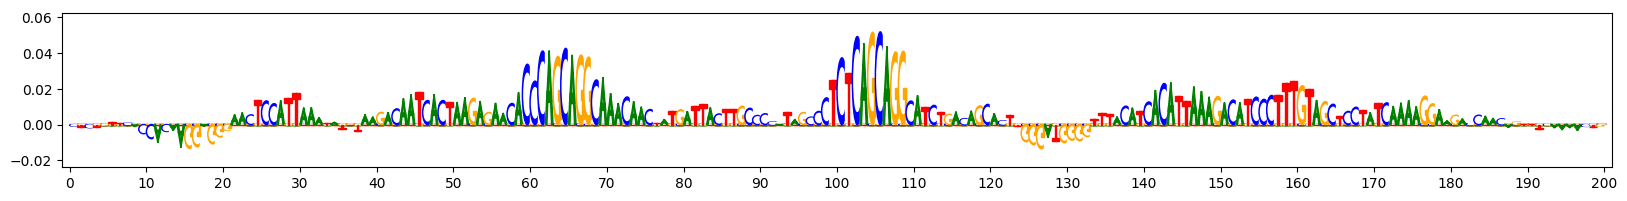

After normalization


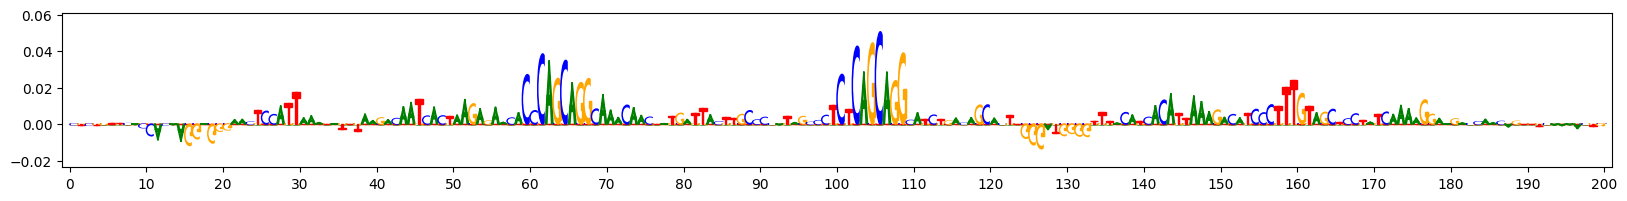

Idx 855 total imp 1.7688685270000002
Before normalization


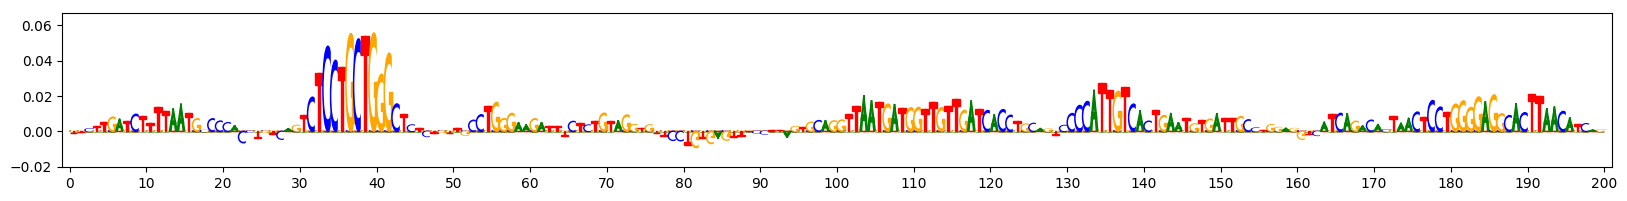

After normalization


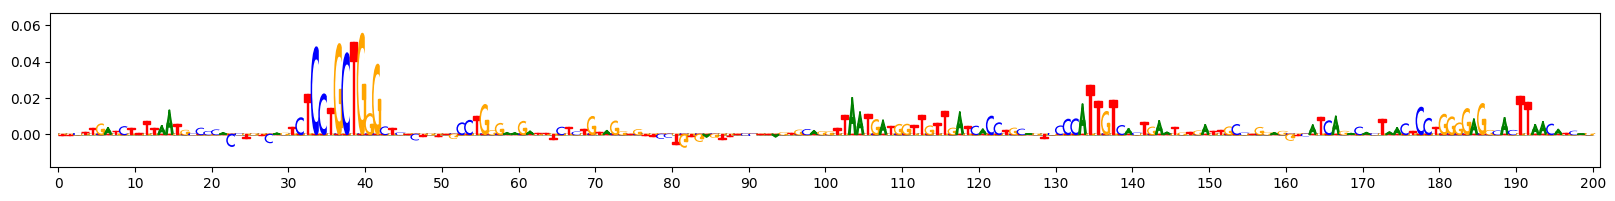

Idx 938 total imp 1.6606393863
Before normalization


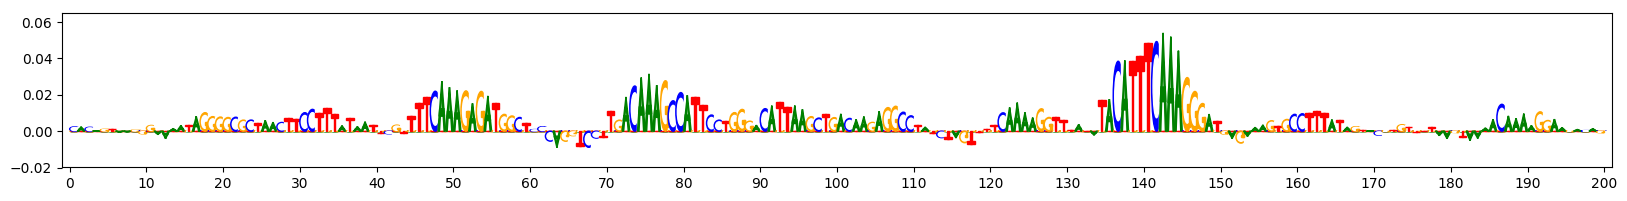

After normalization


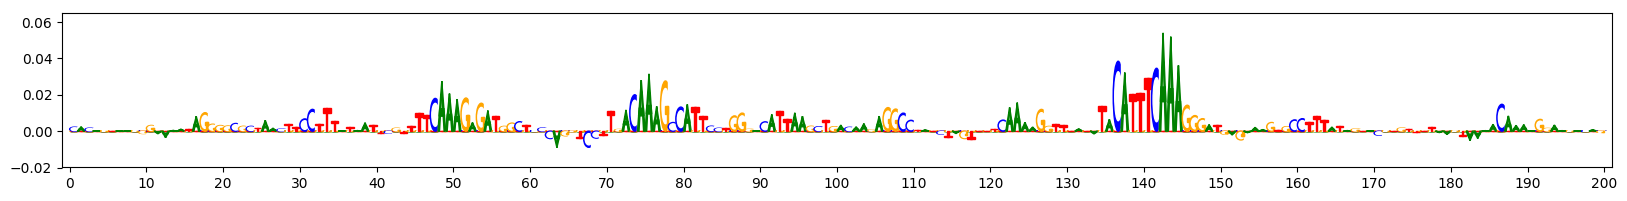

Idx 891 total imp 1.655292229
Before normalization


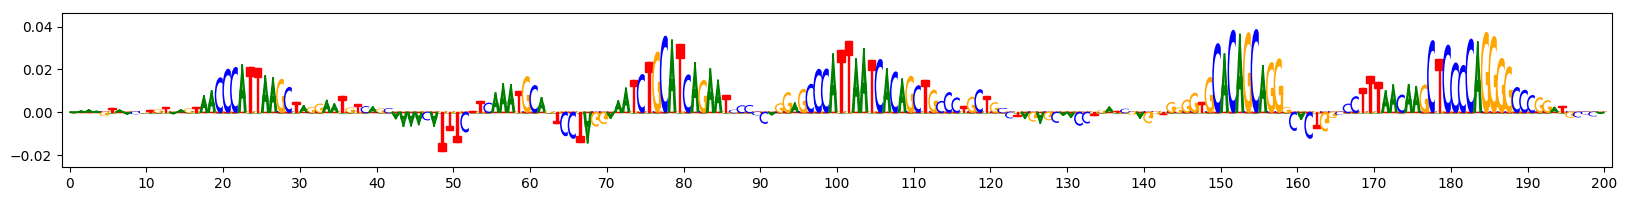

After normalization


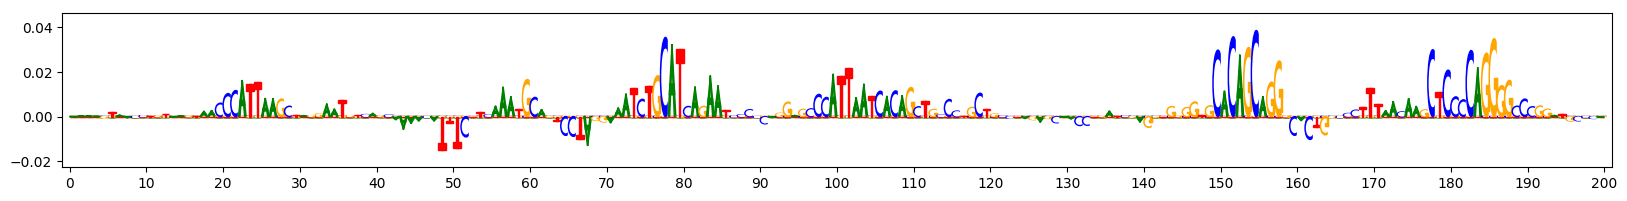

Idx 624 total imp 1.6531603293
Before normalization


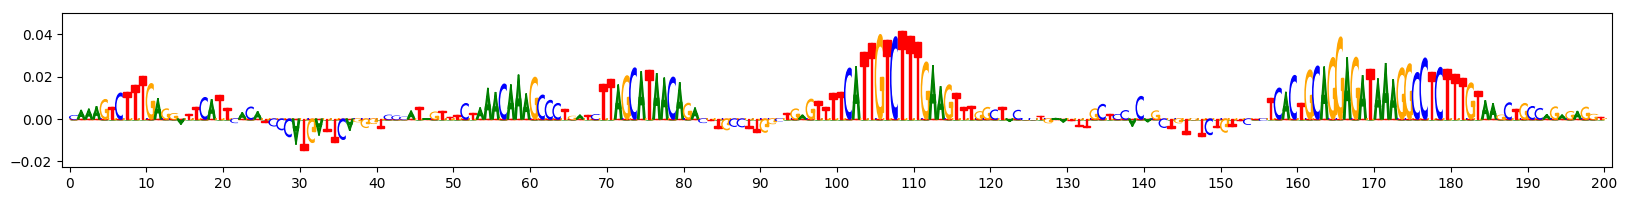

After normalization


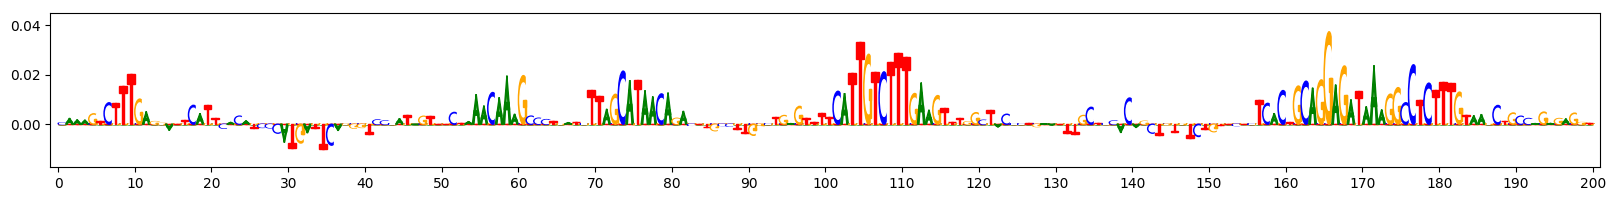

In [71]:
!pip install modisco==5.1.1
from modisco.visualization import viz_sequence
from matplotlib import pyplot as plt
plt.style.use('default')

sorted_indices = [x[0] for x in
                  sorted(enumerate([np.sum(x) for x in impscores]),
                         key=lambda x: -x[1])]
for idx in sorted_indices[:5]:
    print("Idx",idx,"total imp",np.sum(impscores[idx]))
    print("Before normalization")
    viz_sequence.plot_weights(impscores[idx], subticks_frequency=10)
    print("After normalization")
    viz_sequence.plot_weights(normed_impscores[idx], subticks_frequency=10)

### Run TF-MoDISco

On task task0
Computing windowed sums on original
Generating null dist
Computing threshold
Thresholds from null dist were -0.36762881999999986  and  0.324322041
Final raw thresholds are -0.36762881999999986  and  0.324322041
Final transformed thresholds are -0.9660590277777777  and  0.9476215277777778


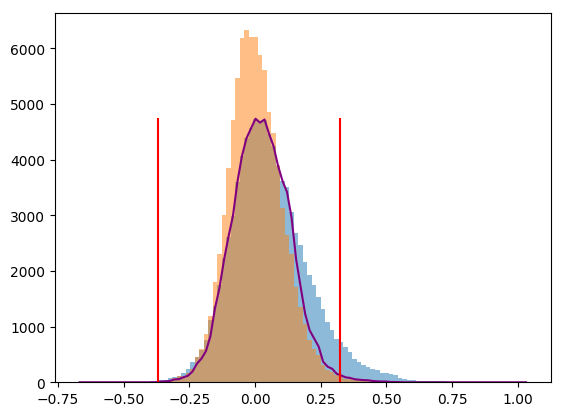

Got 635 coords
After resolving overlaps, got 635 seqlets
Across all tasks, the weakest transformed threshold used was: 0.9476214277777778
635 identified in total
1 activity patterns with support >= 100 out of 3 possible patterns
Metacluster sizes:  [613]
Idx to activities:  {0: '1'}
On metacluster 0
Metacluster size 613
Relevant tasks:  ('task0',)
Relevant signs:  (1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 613
(Round 1) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 2.19 s
Starting affinity matrix computations
Normalization computed in 0.03 s
Cosine similarity mat computed in 0.1 s
Normalization computed in 0.03 s
Cosine similarity mat computed in 0.1 s
Finished affinity matrix computations in 0.22 s
(Round 1) Compute nearest neighbors from coarse affmat
Computed nearest neighbors in 0.04 s
(Round 1) Computing affinity matrix on nearest neighbors
Launching nearest neighbors affmat calculation 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    5.5s finished


Louvain completed 200 runs in 5.880784034729004 seconds
Wrote graph to binary file in 0.40440893173217773 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.636102
After 5 runs, maximum modularity is Q = 0.641703
After 44 runs, maximum modularity is Q = 0.650772
Louvain completed 94 runs in 7.91520881652832 seconds
Preproc + Louvain took 14.317399978637695 s
Got 5 clusters after round 1
Counts:
{3: 72, 2: 132, 0: 191, 1: 148, 4: 57}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 191 seqlets
Trimmed 3 out of 191
Skipped 20 seqlets
Aggregating for cluster 1 with 148 seqlets
Trimmed 7 out of 148
Skipped 17 seqlets
Aggregating for cluster 2 with 132 seqlets
Trimmed 4 out of 132
Skipped 20 seqlets
Aggregating for cluster 3 with 72 seqlets
Trimmed 8 out of 72
Skipped 11 seqlets
Aggregating for cluster 4 with 57 seqlets
Trimmed 0 out of 57
Skipped 12 seqlets
(Round 2) num seqlets: 498
(Round 2) Computing coarse affmat
Beginn

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    4.1s


Louvain completed 200 runs in 5.643962860107422 seconds


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    5.4s finished


Wrote graph to binary file in 0.3862769603729248 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.552861
After 2 runs, maximum modularity is Q = 0.615674
After 4 runs, maximum modularity is Q = 0.617459
After 10 runs, maximum modularity is Q = 0.619979
After 54 runs, maximum modularity is Q = 0.61999
Louvain completed 104 runs in 8.728936433792114 seconds
Preproc + Louvain took 14.857155561447144 s
Got 6 clusters after round 2
Counts:
{4: 20, 0: 168, 1: 131, 2: 122, 3: 38, 5: 19}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 168 seqlets
Trimmed 19 out of 168
Aggregating for cluster 1 with 131 seqlets
Trimmed 11 out of 131
Skipped 4 seqlets
Aggregating for cluster 2 with 122 seqlets
Trimmed 27 out of 122
Aggregating for cluster 3 with 38 seqlets
Trimmed 7 out of 38
Aggregating for cluster 4 with 20 seqlets
Trimmed 2 out of 20
Aggregating for cluster 5 with 19 seqlets
Trimmed 0 out of 19
Got 6 clusters
Splitting into

In [83]:
from modisco.visualization import viz_sequence
from matplotlib import pyplot as plt
plt.style.use('default')
import h5py
import numpy as np
import modisco

#I sum up the null distribution importance scores at each position
# to get the perpos importance scores
# of the null distribution. I decided to use
# the unnormalized dnshuff_impscores (rather than normalized versions
# of these scores) as this made for a more stringent null distribution.
# Figuring out the best way to generate a null distribution for these scores
# is still an open problem.
dnshuff_perposimp = [np.sum(x,axis=-1) for x in dnshuff_impscores]

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
          #target_seqlet_fdr controls the stringency of the threshold used.
          # the default value is 0.2
          target_seqlet_fdr=0.15,
          #min_passing_windows_frac and max_passing_windows_frac can be used
          # to manually adjust the percentile cutoffs for importance
          # scores if you feel that the cutoff
          # defined by the null distribution is too stringent or too
          # lenient. The default values are 0.03 and 0.2 respectively.
          #min_passing_windows_frac=0.03,
          #max_passing_windows_frac=0.2
          seqlets_to_patterns_factory=
              modisco.tfmodisco_workflow
                     .seqlets_to_patterns
                     .TfModiscoSeqletsToPatternsFactory(
                  #kmer_len, num_gaps and num_mismatches are used to
                  # derive kmer embeddings for coarse-grained affinity
                  # matrix calculation. kmer_len=6, num_gaps=1
                  # and num_mismatches=0 means
                  # that kmer embeddings using 6-mers with 1 gap will be
                  # used. The default is to use longer kmers, but this
                  # can take a while to run and can lead to
                  # out-of-memory errors on some systems.
                  # Empirically, 6-mers with 1-gap
                  # seem to give good results.
                  kmer_len=6, num_gaps=1,
                  num_mismatches=0,
          ),
     )(
  #There is only one task, so we just call this 'task0'
  task_names=["task0"],
  contrib_scores={'task0': impscores},                
  hypothetical_contribs={'task0': hyp_impscores},
  one_hot=onehot_data,
  null_per_pos_scores={'task0': dnshuff_perposimp})

num seqlets 152
fwd seq PWM


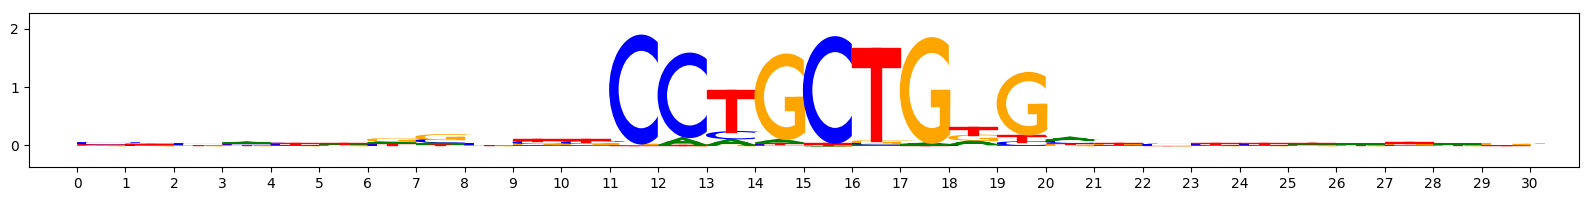

Contrib scores


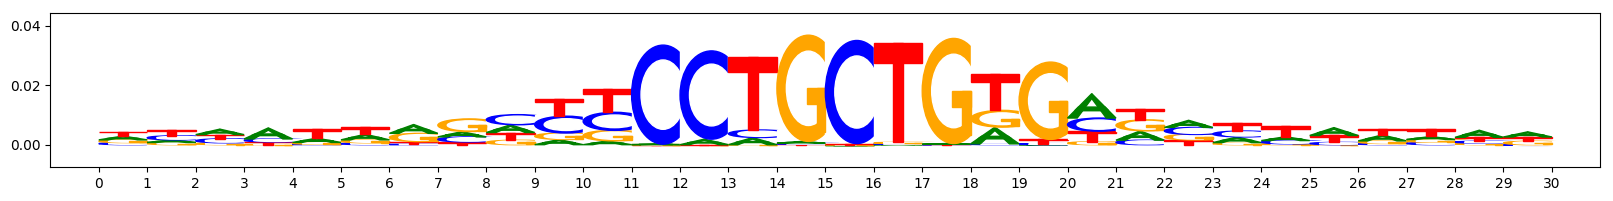

Hyp contrib scores


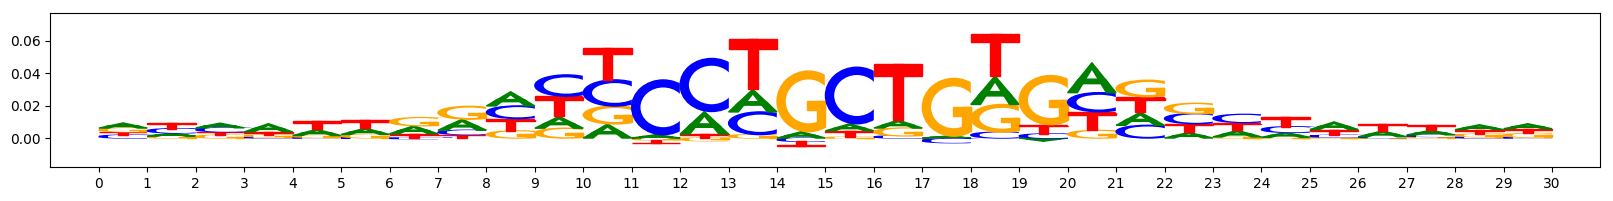

rev seq PWM


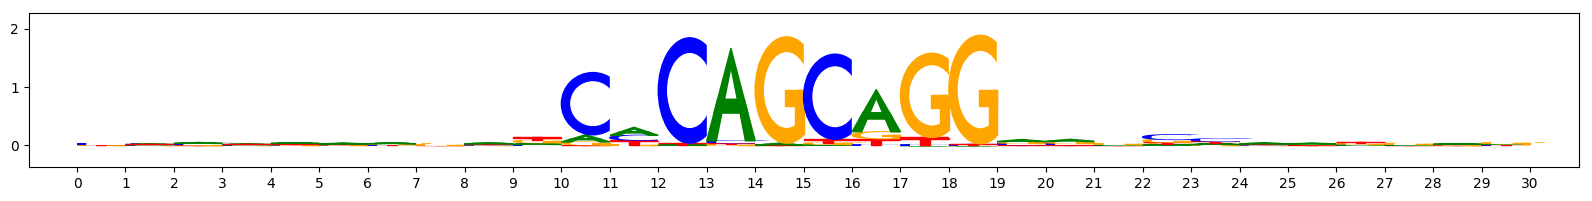

Contrib scores


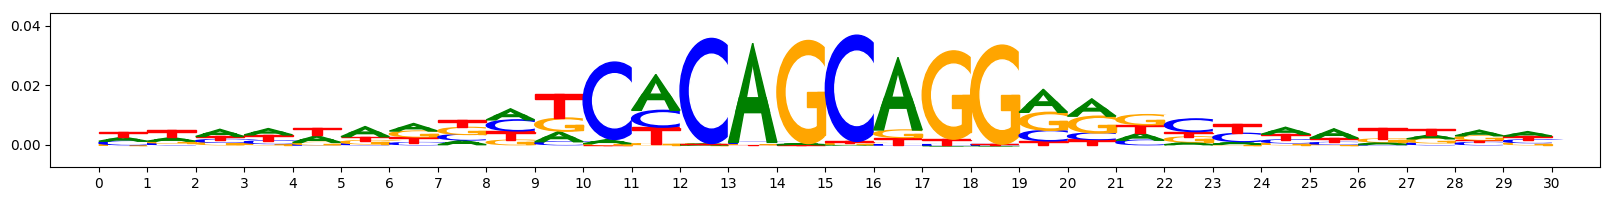

Hyp contrib scores


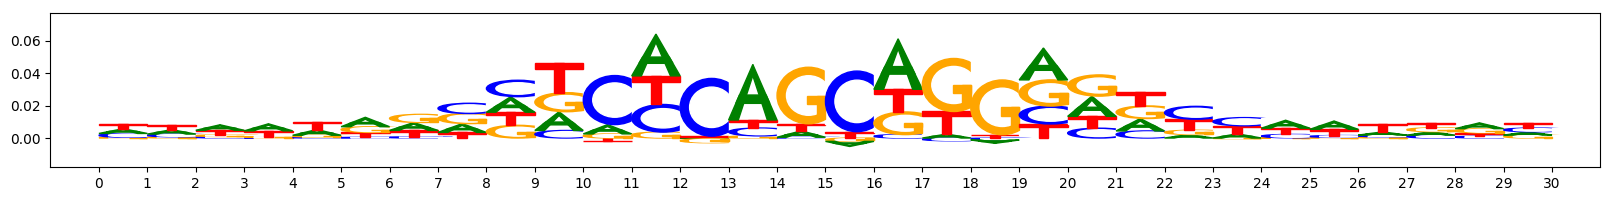

num seqlets 126
fwd seq PWM


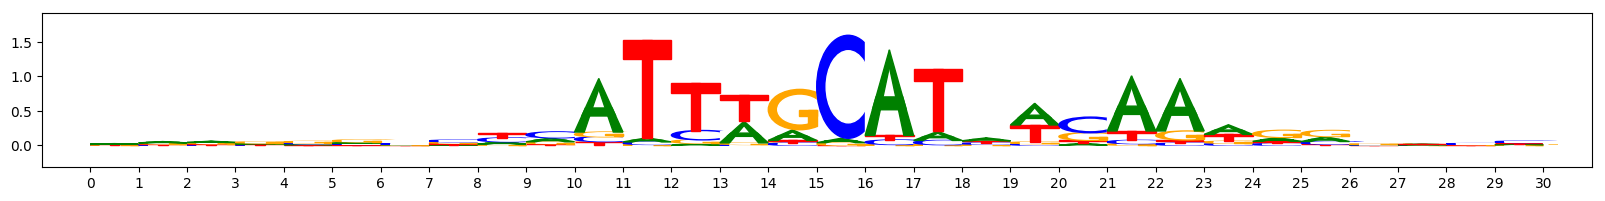

Contrib scores


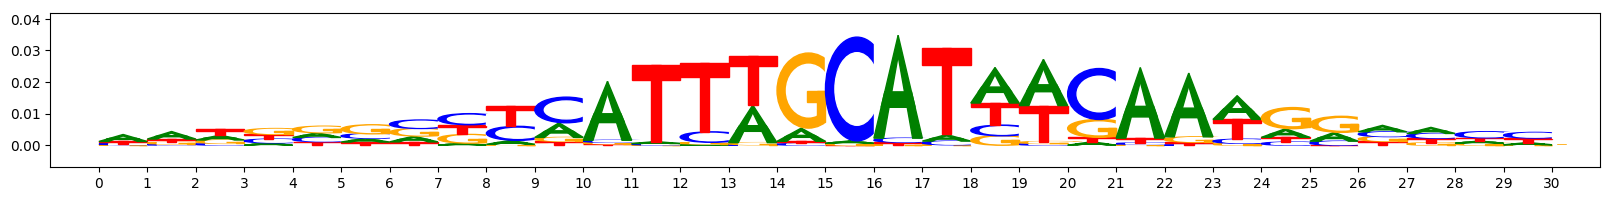

Hyp contrib scores


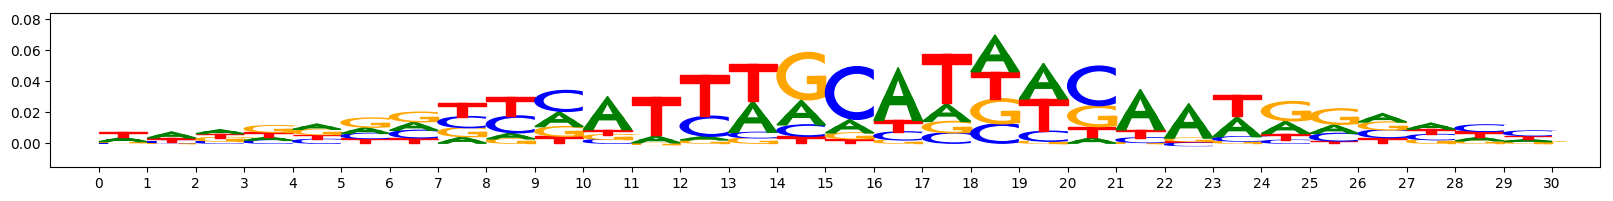

rev seq PWM


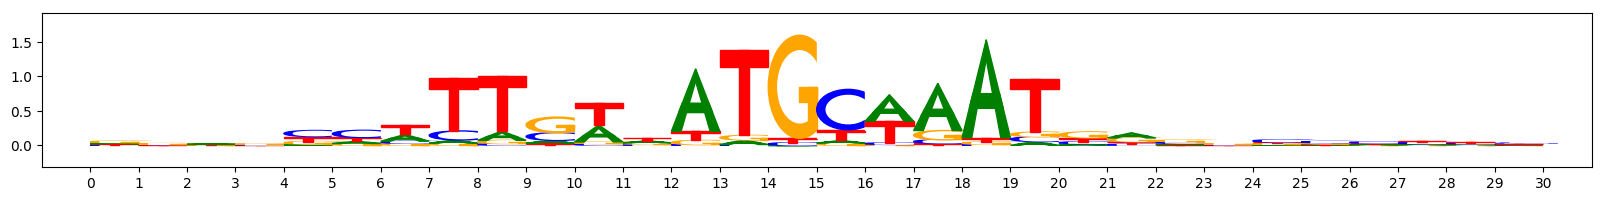

Contrib scores


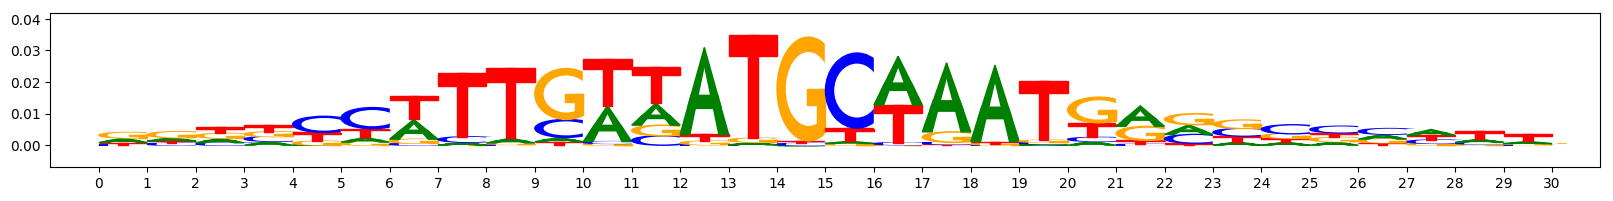

Hyp contrib scores


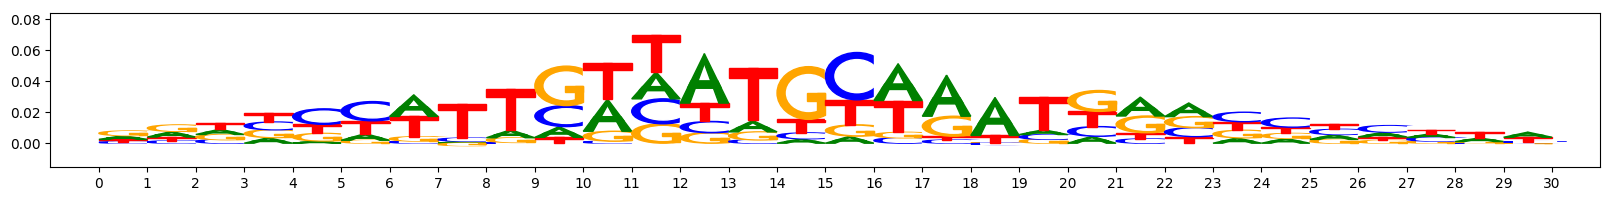

num seqlets 104
fwd seq PWM


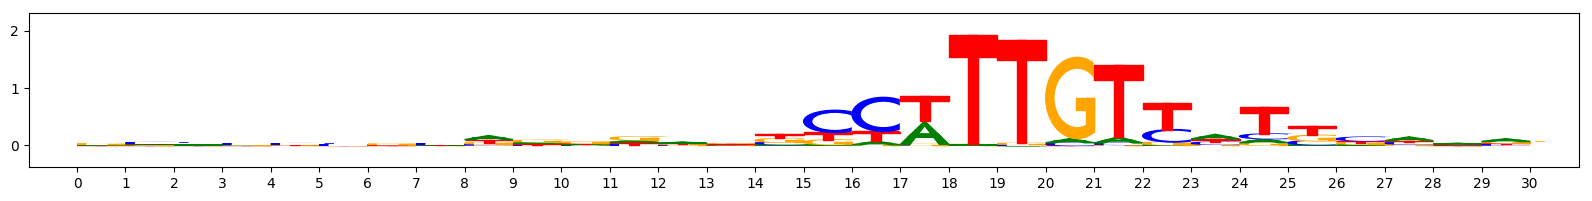

Contrib scores


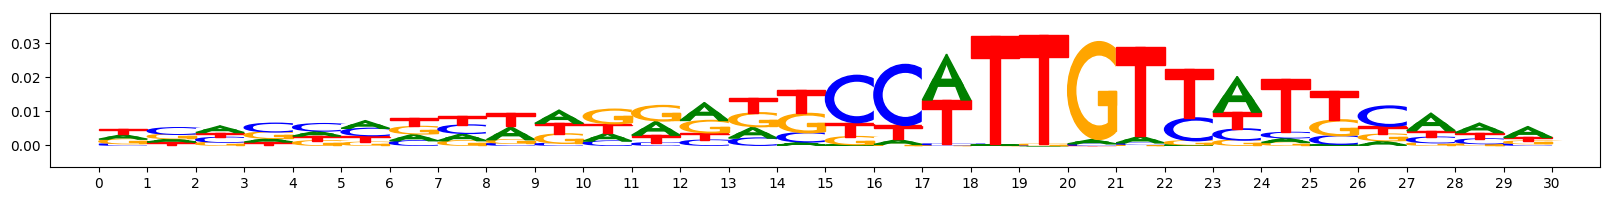

Hyp contrib scores


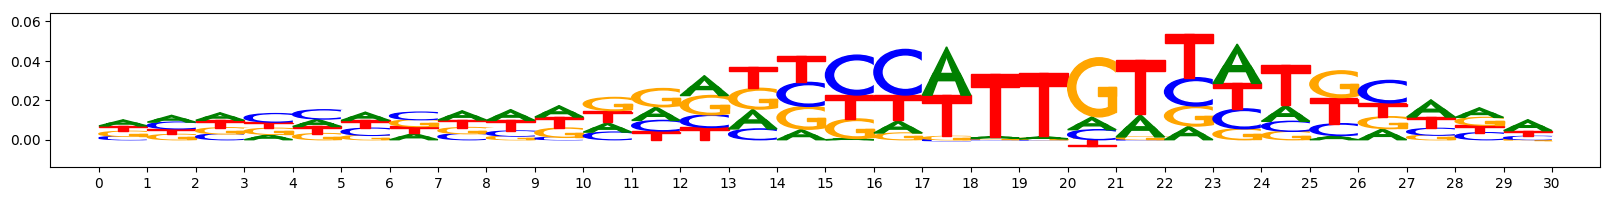

rev seq PWM


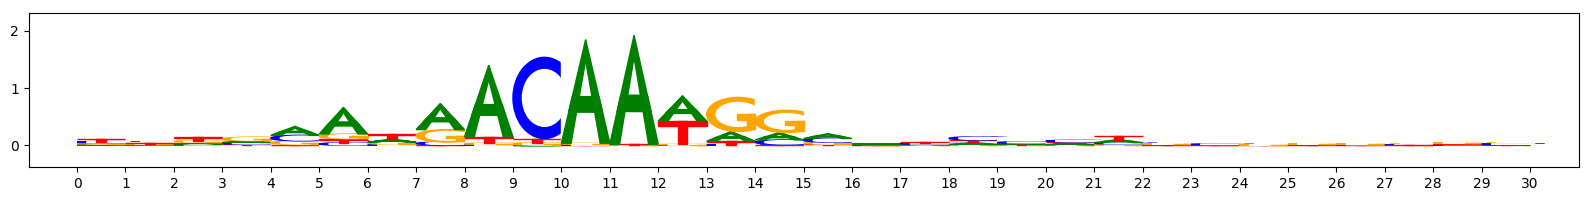

Contrib scores


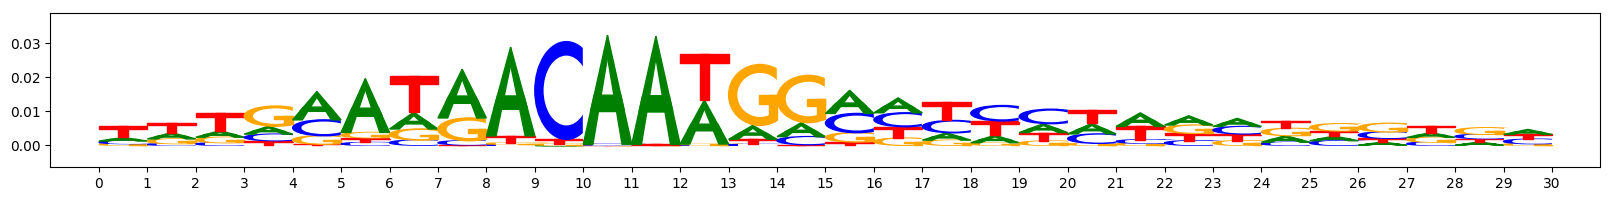

Hyp contrib scores


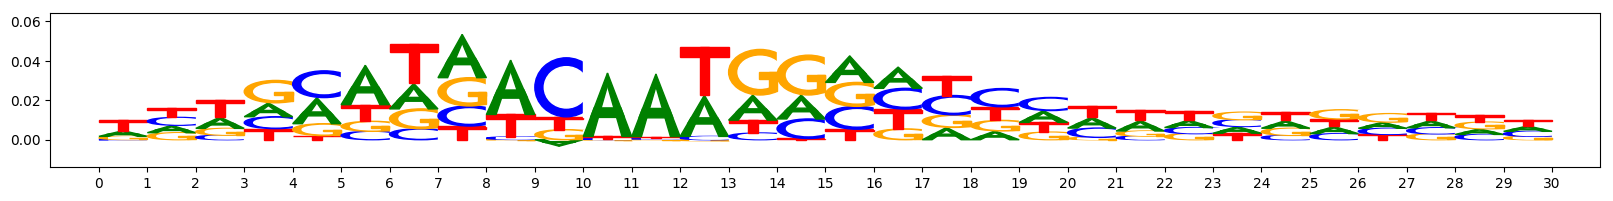

num seqlets 32
fwd seq PWM


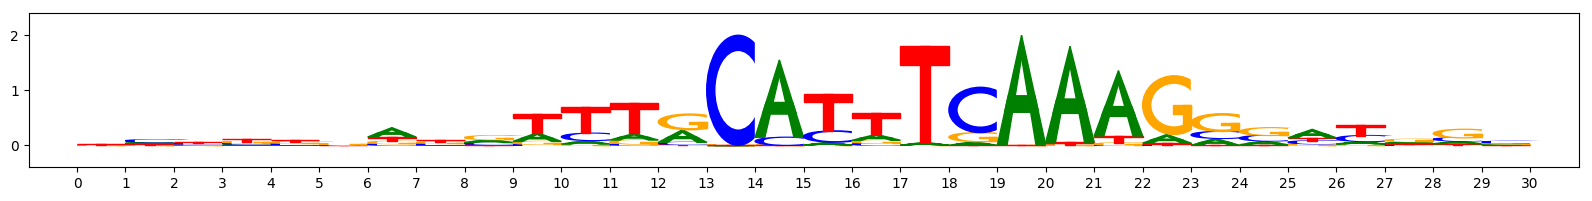

Contrib scores


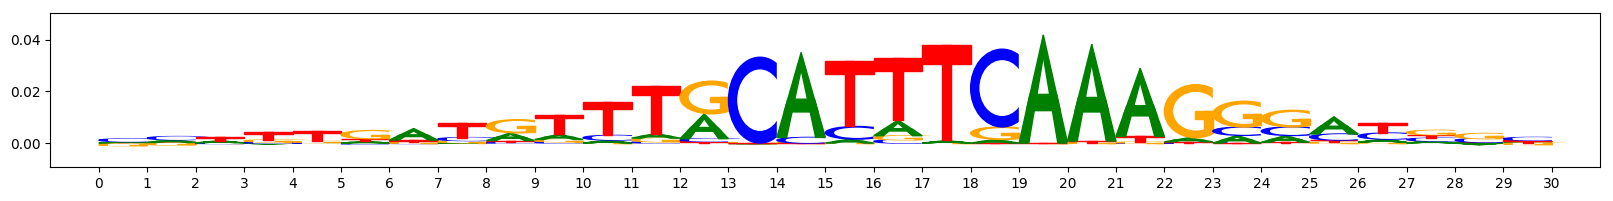

Hyp contrib scores


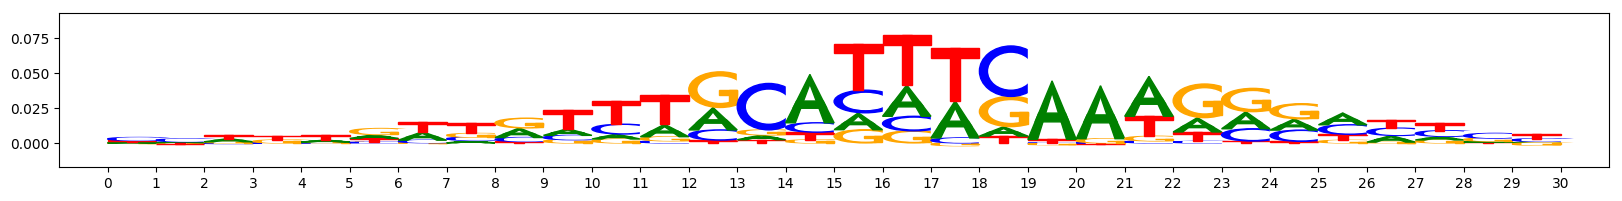

rev seq PWM


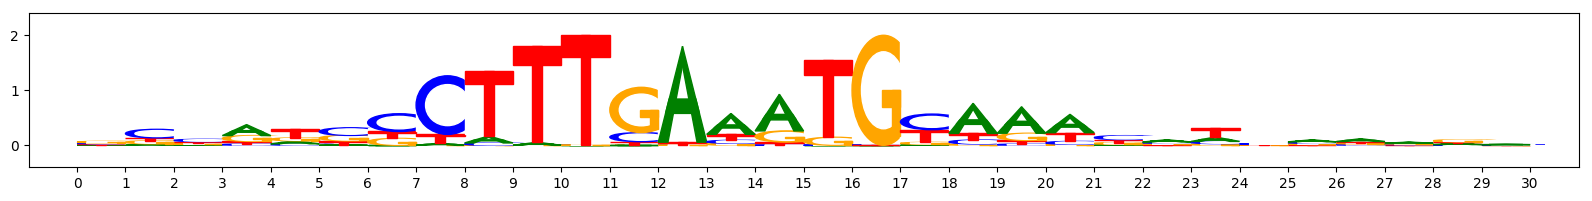

Contrib scores


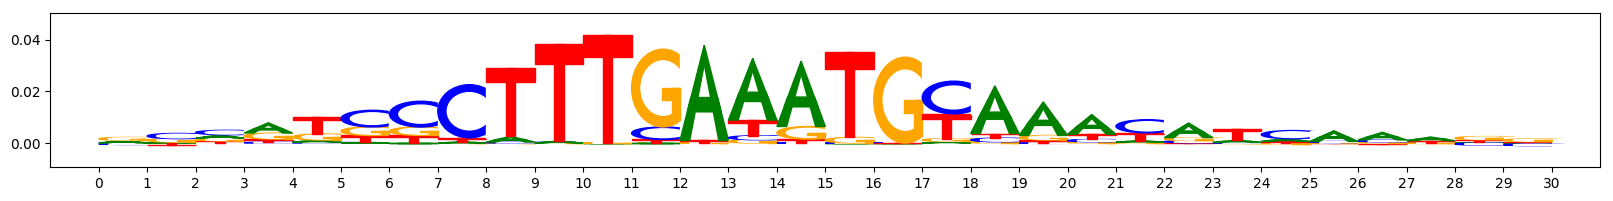

Hyp contrib scores


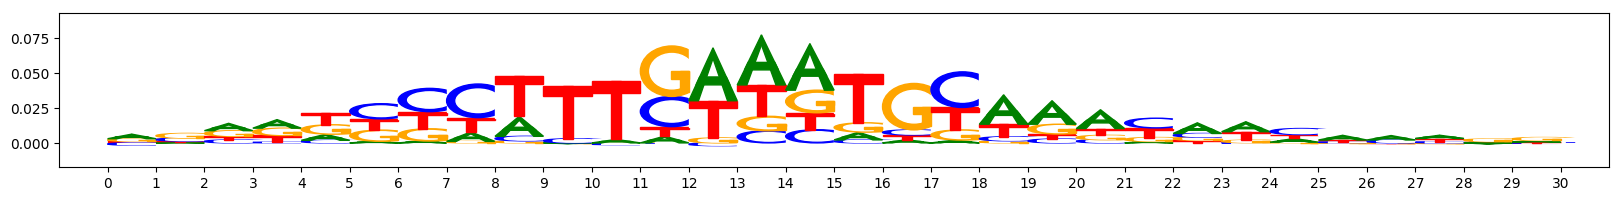

In [84]:
from modisco.aggregator import TrimToBestWindow

trimmer = TrimToBestWindow(window_size=30, track_names=["task0_contrib_scores"])

for i,pattern in enumerate(trimmer(tfmodisco_results
                                   .metacluster_idx_to_submetacluster_results[0]
                                   .seqlets_to_patterns_result.patterns)):
    print("num seqlets",len(pattern.seqlets))
    print("fwd seq PWM")
    viz_sequence.plot_weights(viz_sequence.ic_scale(
        pattern["sequence"].fwd, background=np.array([0.25,0.25,0.25,0.25])))
    print("Contrib scores")
    viz_sequence.plot_weights(pattern["task0_contrib_scores"].fwd)
    print("Hyp contrib scores")
    viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"].fwd)
  
    print("rev seq PWM")
    viz_sequence.plot_weights(viz_sequence.ic_scale(
      pattern["sequence"].rev, background=np.array([0.25,0.25,0.25,0.25])))
    print("Contrib scores")
    viz_sequence.plot_weights(pattern["task0_contrib_scores"].rev)
    print("Hyp contrib scores")
    viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"].rev)